## PEPSI STOCK PRICE ANALYSIS AND PREDICTION

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 237.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


#### Importation of important libraries

In [3]:
%config IPCompleter.greedy=True

In [4]:
import pandas as pd
import numpy as np
import math
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from scipy.stats import norm


%matplotlib inline

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



#### Downloading the dataset from yahoo finance

In [5]:
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

df = pdr.get_data_yahoo("PEP", start="2012-01-01", end=date.today().strftime('%Y-%m-%d'))

[*********************100%***********************]  1 of 1 completed


In [6]:
df.to_csv('Pepsi stock price data')

#### First observations of the dataset

In [7]:
df.head(10).style.background_gradient(cmap="Reds")

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03 00:00:00,66.860001,67.190002,66.360001,66.400002,48.919067,5348800
2012-01-04 00:00:00,66.410004,66.839996,66.120003,66.739998,49.169552,6042400
2012-01-05 00:00:00,66.580002,66.669998,66.120003,66.220001,48.786461,4909100
2012-01-06 00:00:00,66.269997,66.269997,65.290001,65.389999,48.174965,6533000
2012-01-09 00:00:00,65.260002,65.830002,65.010002,65.730003,48.425468,5859600
2012-01-10 00:00:00,65.980003,66.050003,65.470001,65.660004,48.373878,4996000
2012-01-11 00:00:00,65.000000,65.169998,64.129997,65.010002,47.895004,10470200
2012-01-12 00:00:00,65.099998,65.180000,64.470001,64.620003,47.607685,5745700
2012-01-13 00:00:00,64.440002,64.720001,64.300003,64.400002,47.445602,6677900


In [8]:
df.tail(10).style.background_gradient(cmap="Blues")

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-07-12 00:00:00,173.000000,173.320007,168.869995,169.500000,169.500000,5201600
2022-07-13 00:00:00,168.539993,171.440002,167.979996,170.100006,170.100006,4533100
2022-07-14 00:00:00,168.289993,171.160004,167.699997,170.979996,170.979996,4218300
2022-07-15 00:00:00,171.339996,172.919998,170.020004,171.119995,171.119995,4656000
2022-07-18 00:00:00,171.149994,171.240005,167.850006,168.259995,168.259995,3479700
2022-07-19 00:00:00,170.250000,170.750000,168.630005,170.059998,170.059998,4201600
2022-07-20 00:00:00,170.050003,170.570007,167.460007,168.259995,168.259995,3460700
2022-07-21 00:00:00,167.990005,169.410004,167.559998,168.509995,168.509995,3088300
2022-07-22 00:00:00,169.139999,170.570007,168.490005,169.610001,169.610001,3757800


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2657 entries, 2012-01-03 to 2022-07-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2657 non-null   float64
 1   High       2657 non-null   float64
 2   Low        2657 non-null   float64
 3   Close      2657 non-null   float64
 4   Adj Close  2657 non-null   float64
 5   Volume     2657 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 145.3 KB


This dataset contains Pepsi stock price values from "3rd Jan, 2012" till date. It contains 10years of Pepsi stock data price data with 2649 entries and no missing data.

#### Summary of statistics performed on the dataset

In [10]:
df.describe().style.background_gradient(cmap="Greens")

,Open,High,Low,Close,Adj Close,Volume
count,2657.000000,2657.000000,2657.000000,2657.000000,2657.000000,2657.000000
mean,110.831532,111.598506,110.063064,110.861995,97.640367,4851687.881069
std,27.898493,28.168719,27.583683,27.886572,32.934990,2033532.056654
min,62.330002,62.680000,62.150002,62.279999,46.178417,883300.000000
25%,91.550003,91.949997,90.779999,91.550003,72.999031,3599900.000000
50%,108.089996,108.870003,107.470001,108.120003,93.068130,4468600.000000
75%,132.979996,133.949997,131.850006,132.960007,124.353455,5578400.000000
max,177.410004,177.619995,174.649994,177.500000,176.273941,27559700.000000


In [11]:
df[df['High'] == df['High'].max()]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-28,174.529999,177.619995,173.820007,177.5,176.273941,5235800


The highest value of Pepsi stocks between Jan 2012 and July 2022 was on the 28th April, 2022 with an opening price of 174.5 and a closing price of 177.5

In [12]:
df[df['Low'] == df['Low'].min()]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-07,62.330002,62.740002,62.150002,62.619999,46.512512,7509000


The lowest value of pepsi stocks between Jan 2012 and July 2022 was on 7th March, 2012 with an opening price of 62.3 and a closing price of 62.6

### Data Visualization

In [13]:
fig = plt.figure(figsize=(20,10))
sns.set_style('darkgrid')

cm = ['Green','red']

df[['High', 'Low']].iplot(kind='line', title="High vs Low values of Pepsi stocks",
                          color=cm, xaxis_title='Date')
                                          
df[['Open', 'Close']].iplot(kind='line', title="Opening vs Closing values of pepsi stocks", 
                            colors=cm, xaxis_title='Date')

<Figure size 1440x720 with 0 Axes>

In [14]:
df['MA100'] = df['Close'].rolling(100).mean()

In [15]:
df[['Close', 'MA100']].iplot(kind='line', title= "Close price vs 100days moving average", xaxis_title='Date')

##### CREATING THE DAILY RETURNS COLUMN

In [16]:
df['Daily returns'] = df['Adj Close'].pct_change(1).fillna(0)

In [17]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,MA100,Daily returns
Date,,,,,,,,
2012-01-03,66.860001,67.190002,66.360001,66.400002,48.919067,5348800,NaN,0.000000
2012-01-04,66.410004,66.839996,66.120003,66.739998,49.169552,6042400,NaN,0.005120
2012-01-05,66.580002,66.669998,66.120003,66.220001,48.786461,4909100,NaN,-0.007791
2012-01-06,66.269997,66.269997,65.290001,65.389999,48.174965,6533000,NaN,-0.012534
2012-01-09,65.260002,65.830002,65.010002,65.730003,48.425468,5859600,NaN,0.005200


#### ANALYSIS ON THE DAILY RETURNS
##### probability distrubution of the returns

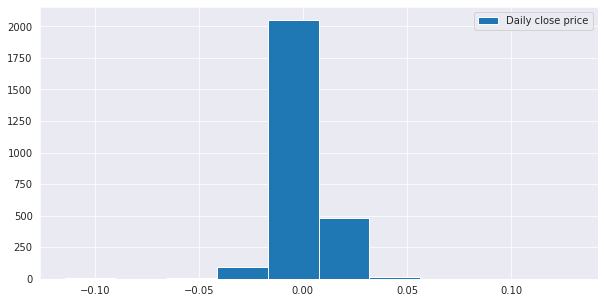

In [18]:
fig = plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
plt.hist(df['Daily returns'],bins=10,label="Daily close price")
plt.legend()

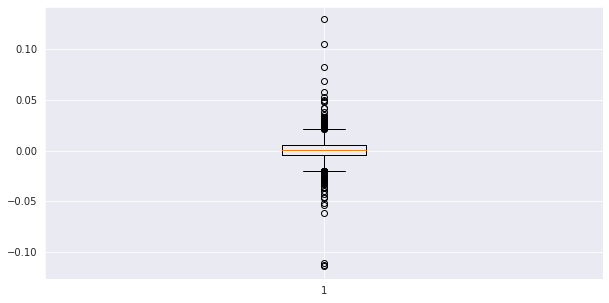

In [19]:
fig = plt.figure(figsize=(10,5))
plt.boxplot(x=df['Daily returns'])
plt.show()

In [20]:
df['Daily returns'].describe()

count    2657.000000
mean        0.000530
std         0.011111
min        -0.114283
25%        -0.004494
50%         0.000521
75%         0.005781
max         0.129366
Name: Daily returns, dtype: float64

##### best day of stock

In [21]:
df[df['Daily returns'] == df['Daily returns'].max()]

,Open,High,Low,Close,Adj Close,Volume,MA100,Daily returns
Date,,,,,,,,
2020-03-17,116.699997,127.860001,116.389999,127.720001,119.768372,14242300,137.3421,0.129366


The highest daily return was on 17th march, 2020 with a return of 0.129

##### worst day of stock

In [22]:
df[df['Daily returns'] == df['Daily returns'].min()]

,Open,High,Low,Close,Adj Close,Volume,MA100,Daily returns
Date,,,,,,,,
2020-03-20,118.239998,118.449997,101.419998,103.93,97.459511,13093200,136.6442,-0.114283


the lowest daily return was on 20th March, 2020 with a daily return of -0.11

#### Plotting daily returns over time

Text(0.5, 1.0, 'Pepsi Stock Daily Returns')

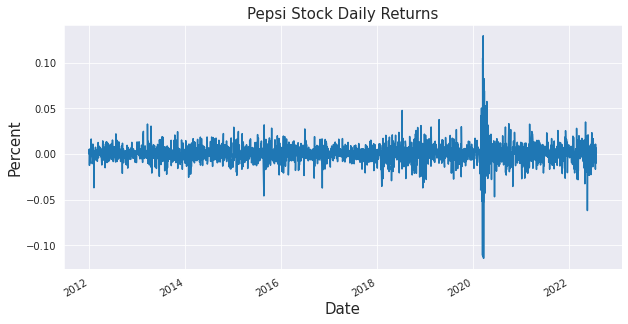

In [23]:
fig = plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
df['Daily returns'].plot()
plt.xlabel("Date", fontsize=15)
plt.ylabel("Percent", fontsize=15)
plt.title("Pepsi Stock Daily Returns", fontsize=15)

#### Moving avg vs close price

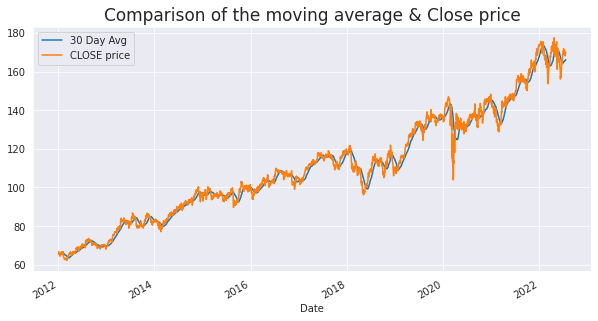

In [24]:
fig = plt.figure(figsize=(10,5))
df['Close'].rolling(window=30).mean().plot(label='30 Day Avg')
df['Close'].plot(label='CLOSE price')
plt.title("Comparison of the moving average & Close price", fontsize=17)
plt.legend(fontsize=10)

#### Are the Daily returns normally distributed

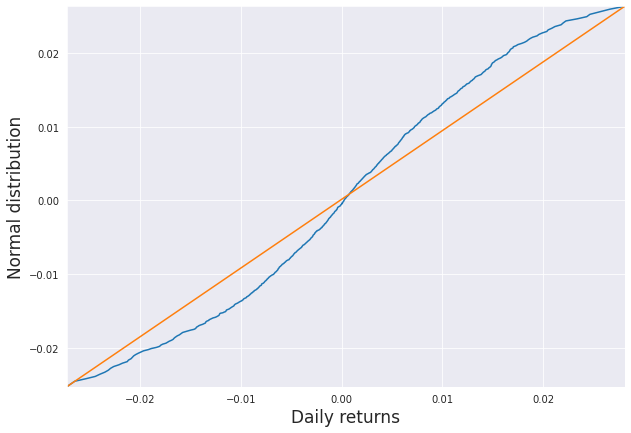

In [25]:
fig = plt.figure(figsize=(10,7))
t = np.linspace(0.01,0.99,1000)
q1 = np.quantile(df['Daily returns'],t)
q2 = norm.ppf(t,loc=np.mean(df['Daily returns']),scale=np.std(df['Daily returns']))
plt.plot(q1,q2)
plt.plot([min(q1),max(q1)],[min(q2),max(q2)])
plt.xlim((min(q1),max(q1)))
plt.ylim((min(q2),max(q2)))
plt.xlabel("Daily returns", fontsize=17)
plt.ylabel("Normal distribution", fontsize=17)
plt.show()

From the graph above, the straight line is the normal distribution but the daily returns is the blue line with isn't straight therefore indicating that the daily returns isn't distributed normally

### Training the dataset

In [26]:
data=df.sort_index(ascending=True,axis=0)

In [27]:
# 1. Filter out the closing market price data
close_data = df.filter(['Close'])
 
# 2. Convert the data into array for easy evaluation
dataset = close_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
# 4. Creating training data size : 70% of the data
training_data_len = math.ceil(len(dataset) * 0.7)
train_data = scaled_data[0:training_data_len  , : ]
 
# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training x and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))

#### Building the LSTM model

In [28]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

2022-07-26 12:36:24.410420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 12:36:24.414083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 12:36:24.414839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 12:36:24.416687: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


#### Compiling and Training the model

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_data2, y_train_data1, epochs=100, batch_size=32, verbose=2)

2022-07-26 12:36:27.964342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-26 12:36:31.357473: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 - 5s - loss: 0.0060
Epoch 2/100
57/57 - 0s - loss: 2.9645e-04
Epoch 3/100
57/57 - 0s - loss: 2.7995e-04
Epoch 4/100
57/57 - 0s - loss: 2.6936e-04
Epoch 5/100
57/57 - 0s - loss: 2.7279e-04
Epoch 6/100
57/57 - 0s - loss: 2.9360e-04
Epoch 7/100
57/57 - 0s - loss: 2.3570e-04
Epoch 8/100
57/57 - 0s - loss: 2.2362e-04
Epoch 9/100
57/57 - 0s - loss: 2.1508e-04
Epoch 10/100
57/57 - 0s - loss: 2.1393e-04
Epoch 11/100
57/57 - 0s - loss: 2.0784e-04
Epoch 12/100
57/57 - 0s - loss: 1.9844e-04
Epoch 13/100
57/57 - 0s - loss: 1.8865e-04
Epoch 14/100
57/57 - 0s - loss: 1.8731e-04
Epoch 15/100
57/57 - 0s - loss: 2.2129e-04
Epoch 16/100
57/57 - 0s - loss: 1.8342e-04
Epoch 17/100
57/57 - 0s - loss: 1.5764e-04
Epoch 18/100
57/57 - 0s - loss: 1.6993e-04
Epoch 19/100
57/57 - 0s - loss: 1.5038e-04
Epoch 20/100
57/57 - 0s - loss: 1.4754e-04
Epoch 21/100
57/57 - 1s - loss: 1.3497e-04
Epoch 22/100
57/57 - 0s - loss: 1.3283e-04
Epoch 23/100
57/57 - 0s - loss: 1.6770e-04
Epoch 24/100
57/57 - 0s - loss: 1.32

#### Testing the model

In [31]:
# 1. Creating a dataset for testing
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
 
# 2.  Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [32]:
len(x_test)

797

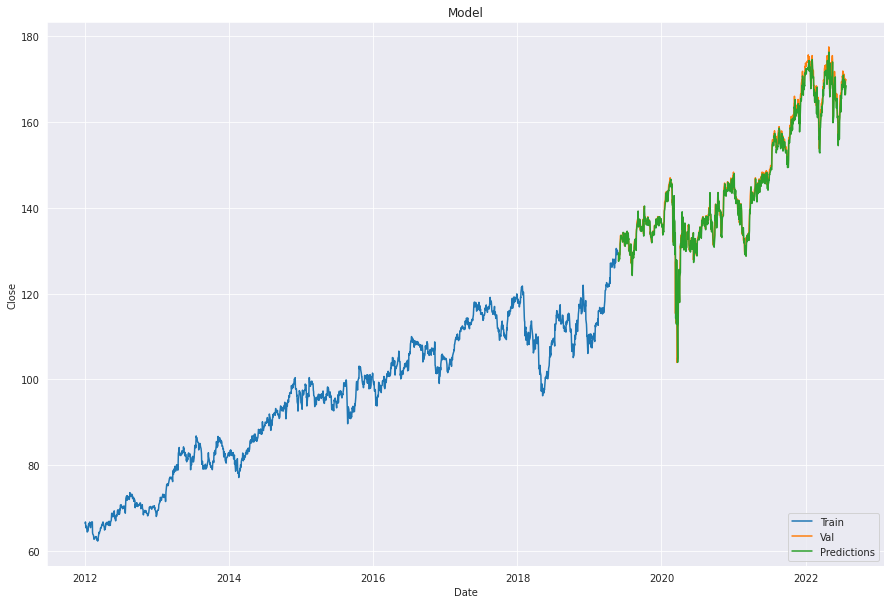

In [33]:
train = data[:training_data_len]
valid = data[training_data_len:]
 
valid['Predictions'] = predictions
 
fig = plt.figure(figsize=(15, 10)) 
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
 
plt.show()

**Checking the root mean squared error**

In [34]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

2.2225143228371804


In [35]:
valid[['Close', 'Predictions']].head(10)

,Close,Predictions
Date,,
2019-05-28,127.629997,129.483215
2019-05-29,128.169998,127.510765
2019-05-30,128.610001,128.200897
2019-05-31,128.000000,128.690445
2019-06-03,128.979996,128.006165
2019-06-04,129.070007,129.060425
2019-06-05,131.389999,129.111679
2019-06-06,131.979996,131.553650
2019-06-07,133.470001,132.050964


In [36]:
model.save('Stock_pred_model.h5')